### <p style="text-align: right;"> &#9989; Eric Ropeta</p>

#### <p style="text-align: right;"> &#9989; Zane Shango, Filip </p>

# Day 18 In-Class: Markov Chain Monte Carlo Parameter Estimation

<img src="http://wiki.ubc.ca/images/thumb/f/f3/MCMCTraversal.png/500px-MCMCTraversal.png" width=500px>

# Markov Chain Monte Carlo fitting

In the pre-class assignment, you used a "grid search" method to find the best-fit value of a model to a dataset.  This doesn't always work well and can be very computationally expensive, particularly when you have many parameters in your model. Toward that end, [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo), or MCMC, methods use random numbers to efficiently sample the parameter space and optimize the model parameters that best fit a given dataset. In this project, we're going to use the [Metropolis-Hastings Algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm), which was invented in the 1950s but is still widely-used today. In fact, it was named one of the [top 10 algorithms of the 20th century!](https://nickhigham.wordpress.com/2016/03/29/the-top-10-algorithms-in-applied-mathematics/)

## How it works

The general idea behind MCMC fitting of our data is that we will start from a guess at our model parameters and "walk" in random directions in parameter space in a way that **on average gets us closer to the best fit to the data.**  We keep track of the points that we've sampled over time (we call this the "trace" of the data), and use those to create a distribution.  The distribution shows us how likely each set of model parameters is to fit the data.

We're going to think about how this works using the model from our pre-class assignment as an example.
Specifically, you're going to revisit fitting data of the form
$$
    f(x) = W x^2 + I
$$
by intelligently searching for optimal $W$ and $I$ (_width_ and _intercept_ of the parabola) values. Specifically, Metropolis-Hastings fitting consists of these steps:
1. Start with an initial guess of the model parameters, $(W_0, I_0)$. 
2. Take a (potential) "step" from $(W_0, I_0)$ in a random direction to produce $(W_1, I_1)$.
3. Calculate the the ["reduced chi-squared"](https://en.wikipedia.org/wiki/Reduced_chi-squared_statistic) values (as done in the pre-class), $\chi_0^2$ and $\chi_1^2$, for the parabolas defined by $(W_0, I_0)$ and $(W_1, I_1)$.
4. Calculate an acceptance probability, $P = e^{-\chi_1^2}/e^{-\chi_0^2}$, as the ratio of two *likelihood functions* (the exponentials).
5. Uniformly generate a random number $r \in [0, 1)$. If $r < P$, "accept" $(W_1, I_1)$ as the next initial guess. Otherwise, discard $(W_1, I_1)$ and generate a new potential step from $(W_0, I_0)$.
6. Repeat this process until you've generated as many points as you care to (100000 isn't bad).

### Notes:

* The Markov-chain part of Markov-chain Monte Carlo means "the next step only depends on the current step."
* If $\chi_1^2 < \chi_0^2$ (i.e. the error from $(W_1, I_1)$ is less than the error from $(W_0, I_0)$), then $P > 1$ and the new point is _always_ accepted.
* By keeping track of the valid steps, we can chart the progress of a "walker" as it (hopefully!) moves towards a set of optimum values. The walker will tend to stay in the region of good fit but its wandering will inform on the range of likely values.
* The randomness here _usually_ prevents walkers from moving in sub-optimal (higher-error) directions but occasionally allows it to happen in hopes of finding even lower error zones.

## What we're doing in class today.

You'll be implementing the Metropolis-Hastings algorithm to give an estimate of the best fit to the model used in the pre-class assignment. For convenience, we provide the code necessary to do the error calculations here, and we also have some extra code to visualize what the Markov Chain "walker" does (which you'll look at after you implement the Metropolis-Hastings algorithm).

<font color='red'>**Before you write any code**,</font> spend some time talking to the people at your table about how to implement steps 1-6 above, and write some pseudo-code on the white board to make sure you understand it. Check with one of the instructors before you start coding!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def make_noisy_data(width, intercept, sigma, num_points):
    xs = np.linspace(-5, 5, num_points)
    ys = width * xs**2 + intercept
    ys_noisy = ys + np.random.normal(0.0, sigma, num_points)
    
    return xs, ys, ys_noisy

def evaluate_parabola(xs, width, intercept):
    """
    Evaluate a polynomial model at a set of x coordinates. 
    Returns an array of y coordinates.
    """
    return np.polyval([width, 0, intercept], xs)

def calculate_error(ys_actual, ys_model, sigma):
    """
    Calculate the chi-squared error between two sets of data
    """
    return ((ys_actual-ys_model)**2/(2*sigma**2)).sum()/(ys_actual.size)

def draw_system_and_model(xs, ys, ys_noisy, sigma, ys_fit = None):
    fig, ax = plt.subplots()
    ax.plot(xs, ys, label="Generating parabola")
    ax.errorbar(xs, ys_noisy, fmt='o', yerr=sigma, label="Noisy data")
    if ys_fit is not None:
        ax.plot(xs, ys_fit, '--', label="Fit")
    
    ax.legend()
    return fig, ax

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

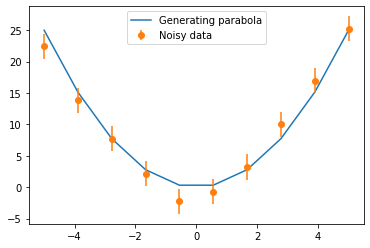

In [2]:
'''
---------------- USER SETS THESE! ----------------
 width = parabola width
 intercept = y-axis intercept
 sigma = error added to the y-values (the noise)
 num_points = number of data points we want to use
'''

width = 1
intercept = 0
sigma = 2.0
num_points = 10

xs, ys, ys_noisy = make_noisy_data(width, intercept, sigma, num_points)
draw_system_and_model(xs, ys, ys_noisy, sigma)

## Implement the Metropolis-Hastings algorithm below

**Make sure to read this**: Implement the algorithm described above (in the "How it works" section), where you take some user-defined number of steps that randomly step in `W` and `I` and are scaled by a `step_size`. This means you don't want to take steps of a discrete size, but instead use a random distribution of step sizes that are scaled by your `step_size` variable. You'll want to take steps that have an equal chance of either decrementing or incrementing the values of `W` and `I`. Also, `W` and `I` don't have to incremented by the exact same amount, in fact, it would best if they weren't so that you can explore more of the parameter space.

Keep track of the following variables as you iterate: 
- Accepted guesses for `width`
- Accepted guesses for `intercepts`
- Accepted steps (the actual size of a step taken) in the `width` direction
- Accepted steps (the actual size of a step taken) in the `intercepts` direction

We have included variables with reasonable values of these quantities to get you started.  In the next section you should plot the guesses in one plot and the steps in another. The plot of the steps should help you debug your code.

In [3]:
# Total number of points we're going to sample (start out with at least 10^4)
num_sample_points = 100000

# Weight factor in front of the random step
step_size = 0.1

# Provide an initial guess for the width and intercept parameters
# As we move the walker around, we'll use these same lists to 
# store our new values so that we can visualize the path later!
# (Note: that means you'll want to append new values to these lists!)
widths = [2]
intercepts = [2]
steps_width = [0]
steps_intercept = [0]

## PUT YOUR CODE HERE ###
widths = [2]
intercepts = [2]

w0 = 2
i0 = 2
y0 = evaluate_parabola(xs,widths[0],intercepts[0])
chi0 = calculate_error(ys_noisy, y0, 2)

for i in range(num_sample_points):
    step_width = np.random.normal()*step_size
    step_intercept = np.random.normal()*step_size
    
    w1 = w0 + step_width
    i1 = i0 + step_intercept
    
    steps_width.append(step_width)
    steps_intercept.append(step_intercept)
    
    y1 = evaluate_parabola(xs,w1,i1)
    chi1 = calculate_error(ys_noisy, y1, sigma)
    
    P = np.exp(-1*chi1)/np.exp(-1*chi0)
    r = np.random.uniform()
    
    if r < P:
        widths.append(w1)
        w0 = w1
        intercepts.append(i1)
        i0 = i1
        y_0 = evaluate_parabola(xs,widths[-1],intercepts[-1])
        chi0 = calculate_error(ys_noisy,y_0,sigma)
        
    else:
        continue

print(len(widths))

79001


# Plotting

## Where did the walker...walk?

First, we make a raw plot of the steps in each direction.  This plot should look like a spherical blob centered about `0`

Second, we make a raw plot of the trace of the Markov Chain. In the plot below, `X` is the user-chosen "generating" value of (`width`, `intercept`), `start` is the initial guess, and `stop` is where the walker ended up. `X` and `stop` are not necessarily near each other, since the MCMC 'walker' has randomness built in and can move away from the best fit point (though it is unlikely)! Notice what happens if the walker starts far from the best fit point.

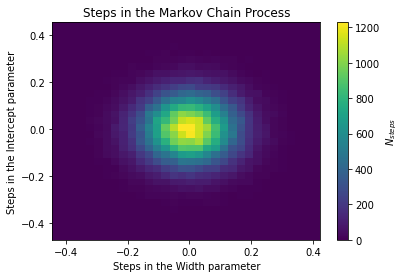

In [4]:
plt.hist2d(steps_width, steps_intercept, bins=32)

plt.xlabel('Steps in the Width parameter')
plt.ylabel('Steps in the Intercept parameter')
plt.title('Steps in the Markov Chain Process');
cb = plt.colorbar()
cb.set_label("$N_{steps}$")

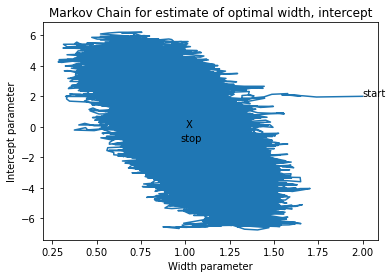

In [5]:
plt.plot(widths, intercepts)

plt.annotate('start', xy=(widths[0], intercepts[0]))
plt.annotate('stop', xy=(widths[-1], intercepts[-1]))
plt.annotate('X', xy=(width, intercept))

plt.xlabel('Width parameter')
plt.ylabel('Intercept parameter')
plt.title('Markov Chain for estimate of optimal width, intercept');

## This is not nearly as informative as it could be.  

The above plot reveals that the walker intersects its own path many many times over the course of its journey. By using a 2D histogram, we can see where the MCMC walker spends most of its time as it wanders around our parameter space. We're going to look at the log of the 2D histogram, for the same reasons we looked at the log of the $\chi^2$ value in the pre-class assignment - there's a lot of dynamic range.  The region where there are lots of points in the histogram represent areas where the walker spent more time: $(W, I)$ parameters that better fit the data.

In the plot below,
* `X` marks the generating width and intercept parameters
* `best` marks the peak of the 2-d histogram (the most likely value and thus the estimate for the fitting parameters)



Text(0.5, 0, 'Width parameter')

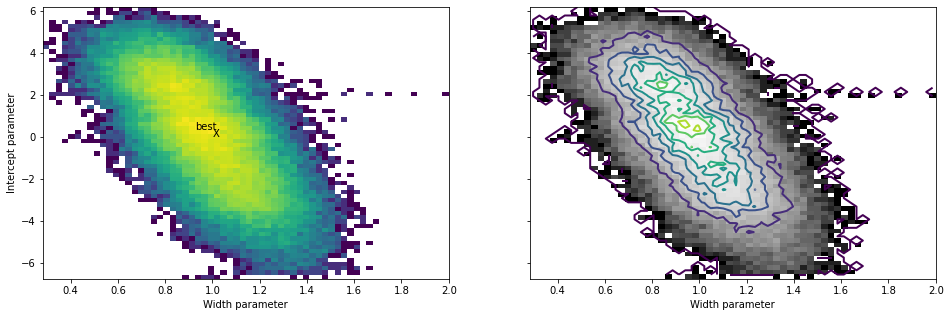

In [6]:
from matplotlib.colors import LogNorm

fig, [colored, bw] = plt.subplots(1,2, sharey=True, figsize = (16, 5))

counts, xbin, ybin, img = colored.hist2d(widths, intercepts, bins=64, norm=LogNorm())
colored.annotate('X', xy=(width, intercept))

# use np.argwhere() to find the bin(s) with the max counts
max_location = np.argwhere(counts == counts.max())

# Use the location of the max to find the best width and intercept parameters
best_width = xbin[max_location[0,0]]
best_intercept = ybin[max_location[0,1]]
colored.annotate('best', xy=(best_width, best_intercept))

bw.hist2d(widths, intercepts, bins=60, norm=LogNorm(), cmap='gray')
bw.contour(0.5*(xbin[1:]+xbin[:-1]), 0.5*(ybin[1:]+ybin[1:]), counts.transpose(), linewidths=2)

colored.set_xlabel("Width parameter")
colored.set_ylabel("Intercept parameter")
bw.set_xlabel("Width parameter")

**Question:** How does the most likely region compare to the locations of the 'true' value and the "best" model value?

They true and best values are in the highest density areas.

We also will show the 1D histograms of the walker positions when collapsed into one dimension (i.e., just the values of `width` and, separately, the values of `intercept`). The 1D histogram can be misleading---the peak of this histogram is not always the _true_ best-fit value when you look at the fit in the maximum number of dimensions!

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

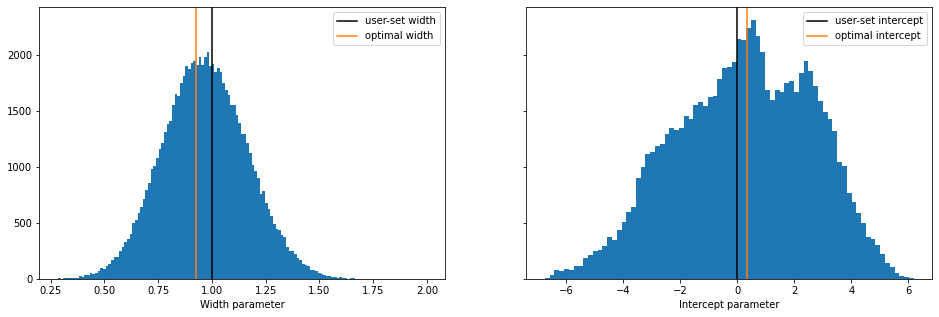

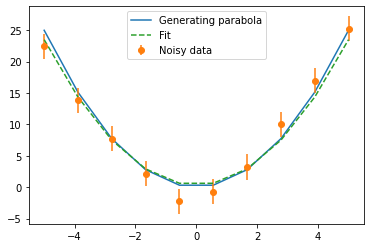

In [7]:
fig, [width_hist, intercept_hist] = plt.subplots(1,2, sharey=True, figsize = (16, 5))

width_hist.hist(widths, bins='auto');
width_hist.set_xlabel("Width parameter")
width_hist.axvline(width, color = 'black', label="user-set width")
width_hist.axvline(best_width, color = '#ff7f0e', label='optimal width')
width_hist.legend()

intercept_hist.hist(intercepts, bins='auto');
intercept_hist.set_xlabel("Intercept parameter")
intercept_hist.axvline(intercept, color = 'black', label="user-set intercept")
intercept_hist.axvline(best_intercept, color = '#ff7f0e', label="optimal intercept")
intercept_hist.legend()

# Draw the data again, this time with the fit superimposed 
ys_fit = evaluate_parabola(xs, best_width, best_intercept)
draw_system_and_model(xs, ys, ys_noisy, sigma, ys_fit)

**Question:** Does the best-fit model produce exactly the same parabola as the model you started out with?  Why do you think that you get the result that you do?

*Put your answer here!*

# Some questions to answer

All of the questions below are asking for a **qualitative explanation** of what happens to the confidence region plot (the 2D histogram) when various model parameters are changed.

1.  What happens if you re-run the MCMC code several times without changing anything?  In other words, if you generate several different random instances, are the results generally similar, or do they vary widely?

2.  What happens to your confidence region as you change the errors in the model data?  In other words, how does the range of plausible $(W,I)$ values change as you make ```sigma``` bigger or smaller?

3.  What happens when you change your initial guess for $(W_0,I_0)$?  Try setting this to values that are quite close to the 'true' value, and then quite far away.

4.  What happens when you change the number of steps that your model takes?  If you make it a factor of 10 bigger or smaller, how does that change the outcome?

1. The results can vary widely. They're generally similar, but every now and again it'll vary widely. 
2. If sigma gets smaller, our confidence should get bigger because it should follow a parabola better.
3. If it's close to true, it doesn't change much but it completely changes things with more different values.
4. The bigger the steps, the more it dances around the starting point, and it creates a lower chance of ending up near the origin. 

-----
### Congratulations, we're done!

Now, you just need to submit this assignment by uploading it to the course <a href="https://d2l.msu.edu/">Desire2Learn</a> web page for today's dropbox (Don't forget to add your names in the first cell).
